# Tests on Controllability and Robustness on Name Pair Task with Testing on Unseen Data

In [59]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
# os.environ['TORCH_USE_CUDA_DSA'] = '1'

In [60]:
import torch
import torchtext
from lightning.pytorch.loggers.wandb import WandbLogger
import torchmetrics

import numpy as np
import wandb
import torchinfo
from contextlib import nullcontext
from  tqdm import tqdm, trange
import argparse


import sys; sys.path += ['..']
from language_models import TransformerLM, configure_optimizers

## Config

In [61]:
args = argparse.Namespace(
    batch_size=128, n_epochs=60, log_on_step=True,
    wandb_project="controllability-robustness-test", run_name='hello', 
    n_layers=3, n_heads=4, d_model=128, dff=128*4)

In [62]:
# region some configuration
device = 'cuada'
device_type = 'cuda' if 'cuda' in device else 'cpu' # for later use in torch.autocast
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16'
# dtype = 'float32'
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]

ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)
# wandb logging
wandb_log = False
wandb_project = args.wandb_project
# endregion


## Data

In [74]:

# get data and vocab for the first 300 samples
data_path = '../name_pairs_dataset/full-sentences.txt'
with open(data_path) as f:
    data_orginal = f.read().splitlines()[:300]
    last_names = [x.split(' ')[-1] for x in data_orginal]

with open('../name_pairs_dataset/first-names.txt') as f:
    first_names = f.read().splitlines()[:300]


# create vocab map
vocab = first_names + last_names
vocab = [x.lower() for x in vocab]
vocab += ['has', 'last', 'name', '[UNK]', '[sep]']
vocab = list(set(vocab))

vocab_map = {vocab: i for i, vocab in enumerate(vocab)}

vocab_size = len(vocab)
print('vocab size: ', vocab_size) # vocab size is very large; especially for a task this simple


# sample different last name in ctx of the same sentence, keep first name the same
test_data_counterfactual = [f'{" ".join(sentence.split(" ")[:-1])} {last_names[np.random.randint(len(last_names))]}' for sentence in data_orginal]
test_data_counterfactual = [f'{sentence} [SEP] {sentence}' for sentence in test_data_counterfactual]

# sample different first and last names in ctx of the same sentence
test_data_counterfactual_irrelevant = [f'{first_names[np.random.randint(len(first_names))]} {" ".join(sentence.split(" ")[1:])}' for sentence in data_orginal]
test_data_counterfactual_irrelevant = [f'{" ".join(sentence.split(" ")[:-1])} {last_names[np.random.randint(len(last_names))]}' for sentence in test_data_counterfactual_irrelevant]
test_data_counterfactual_irrelevant = [f'{test_data_counterfactual_irrelevant[i]} [SEP] {data_orginal[i]}' for i in range(len(data_orginal))]
print(test_data_counterfactual_irrelevant[:5])
print(test_data_counterfactual[:5])

# modify sentence to include [SEP] token
data = [f'{sentence} [SEP] {sentence}' for sentence in data_orginal]

tokenized_data = [sentence.strip().lower().split(' ') for sentence in tqdm(data)]
test_tokenized_data_counterfactual = [sentence.strip().lower().split(' ') for sentence in tqdm(test_data_counterfactual)]
test_tokenized_data_counterfactual_irrelevant = [sentence.strip().lower().split(' ') for sentence in tqdm(test_data_counterfactual_irrelevant)]

integer_ids = [torch.tensor([vocab_map.get(token, vocab_map['[UNK]']) for token in tokens]) for tokens in tqdm(tokenized_data)]
integer_ids = torch.tensor(np.array(integer_ids))
integer_test_ids_counterfactual = [torch.tensor([vocab_map.get(token, vocab_map['[UNK]']) for token in tokens]) for tokens in tqdm(test_tokenized_data_counterfactual)]
integer_test_ids_counterfactual = torch.tensor(np.array(integer_test_ids_counterfactual))
integer_test_ids_counterfactul_irrelevant = [torch.tensor([vocab_map.get(token, vocab_map['[UNK]']) for token in tokens]) for tokens in tqdm(test_tokenized_data_counterfactual_irrelevant)]
integer_test_ids_counterfactul_irrelevant = torch.tensor(np.array(integer_test_ids_counterfactul_irrelevant))


# create dataset and dataloader
x = integer_ids[:, :-1]
y = integer_ids[:, 1:]
x_test_counterfactual = integer_test_ids_counterfactual[:, :-1]
y_test_counterfactual = integer_test_ids_counterfactual[:, 1:]
x_test_counterfactual_irrelevant = integer_test_ids_counterfactul_irrelevant[:, :-1]
y_test_counterfactual_irrelevant = integer_test_ids_counterfactul_irrelevant[:, 1:]


dataset = torch.utils.data.TensorDataset(x, y)
test_dataset_counterfactual = torch.utils.data.TensorDataset(x_test_counterfactual, y_test_counterfactual)
test_dataset_counterfactual_irrelevant = torch.utils.data.TensorDataset(x_test_counterfactual_irrelevant, y_test_counterfactual_irrelevant)

train_dataset = dataset[:100] # NOTE: smaller dataset for testing
val_dataset = dataset[100:200] # NOTE: smaller dataset for testing
test_dataset = dataset[200:300] # NOTE: smaller dataset for testing
test_dataset_counterfactual = test_dataset_counterfactual[:100] # NOTE: smaller dataset for testing
test_dataset_counterfactual_irrelevant = test_dataset_counterfactual_irrelevant[:100] # NOTE: smaller dataset for testing

train_dl = torch.utils.data.DataLoader(dataset, batch_size=args.batch_size, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_dataset, batch_size=args.batch_size, shuffle=False)
test_dl = torch.utils.data.DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False)
test_dl_counterfactual = torch.utils.data.DataLoader(test_dataset_counterfactual, batch_size=args.batch_size, shuffle=False)
test_dl_counterfactual_irrelevant = torch.utils.data.DataLoader(test_dataset_counterfactual_irrelevant, batch_size=args.batch_size, shuffle=False)
seq_len = x.shape[1]

vocab size:  604
['Abbi has last name CORTINA [SEP] Aaren has last name DURLAND', 'Angelique has last name FRAMPTON [SEP] Aarika has last name ROBITAILLE', 'Angelika has last name AMBROSIUS [SEP] Abagael has last name SJOGREN', 'Adriaens has last name HAUSKINS [SEP] Abagail has last name MENGSTEAB', 'Abbe has last name HONGO [SEP] Abbe has last name OEHLENSCHLAGE']
['Aaren has last name NIEMIEL [SEP] Aaren has last name NIEMIEL', 'Aarika has last name MCLESKEY [SEP] Aarika has last name MCLESKEY', 'Abagael has last name KEEHAN [SEP] Abagael has last name KEEHAN', 'Abagail has last name LANTRIP [SEP] Abagail has last name LANTRIP', 'Abbe has last name BRAEGELMANN [SEP] Abbe has last name BRAEGELMANN']


100%|██████████| 300/300 [00:00<00:00, 96799.08it/s]


## Model

In [75]:
import lightning as L
import matplotlib.pyplot as plt

class LitLanguageModel(L.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.mismatched_sequences = []

    def training_step(self, batch, batch_idx):
        x, y = batch
        # with ctx:
        logits, loss = self.model(x, y)

        self.log('train_loss', loss, prog_bar=True, logger=True, on_step=args.log_on_step, on_epoch=True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        # with ctx:
        logits, loss = self.model(x, y)

        perplexity = torchmetrics.functional.text.perplexity(logits, y)

        self.log(f"val_loss", loss, prog_bar=True, logger=True, add_dataloader_idx=False)
        self.log(f'val_perplexity', perplexity, prog_bar=True, logger=True, add_dataloader_idx=False)

    def test_step(self, batch, batch_idx):
        x, y = batch
        # with ctx:
        logits, loss = self.model(x, y)

        perplexity = torchmetrics.functional.text.perplexity(logits, y)

        self.log(f"test_loss", loss, prog_bar=True, logger=True, add_dataloader_idx=False)
        self.log(f'test_perplexity', perplexity, prog_bar=True, logger=True, add_dataloader_idx=False)
        
        # Calculate per position accuracy
        per_pos_acc = self.per_position_accuracy(logits, y)  
        
        # Calculate whole sequence accuracy
        seq_acc = self.sequence_accuracy(logits, y)
        
        # Log both metrics
        self.log('test_seq_acc', seq_acc, on_step=True, on_epoch=True)
        self.log('test_per_pos_acc_mean', per_pos_acc.mean(), on_step=True, on_epoch=True)
        
        # plot per position accuracy
        plt.plot(per_pos_acc.cpu().numpy())
        plt.title('Per Position Accuracy')
        plt.xlabel('Position')
        plt.ylabel('Accuracy')
        
        self.capture_mismatches(logits, y, x)
        
    def sequence_accuracy(self, preds, targets):
        # Convert logits to predictions
        preds = torch.argmax(preds, dim=-1)
        # Check if entire sequences match
        correct = torch.all(preds == targets, dim=1)
        accuracy = torch.mean(correct.float())
        return accuracy
    
    def per_position_accuracy(self, logits, targets):
        preds = torch.argmax(logits, dim=-1)
        correct = preds == targets
        per_position_acc = correct.float().mean(dim=0)
        return per_position_acc
    
    def capture_mismatches(self, preds, targets, inputs, max_examples=1000):
        """
        Store examples of sequences where the predictions do not match the targets.
        
        Args:
            preds (torch.Tensor): The model's predicted sequences.
            targets (torch.Tensor): The actual sequences.
            inputs (torch.Tensor): The input sequences to the model.
            max_examples (int): Maximum number of mismatched sequences to store.
        """
        # Convert predictions to class indices
        preds = torch.argmax(preds, dim=-1)
        mismatches = preds != targets
        
        # Iterate over the batch to find mismatches
        for i in range(mismatches.size(0)):
            if torch.any(mismatches[i]) and len(self.mismatched_sequences) < max_examples:
                mismatch_data = {
                    'input': inputs[i].cpu().numpy(),
                    'predicted': preds[i].cpu().numpy(),
                    'target': targets[i].cpu().numpy()
                }
                self.mismatched_sequences.append(mismatch_data)
                
        
                
    # def on_test_epoch_end(self):
    #     # Already stored mismatched sequences in self.mismatched_sequences
    #     if self.mismatched_sequences:
    #         print("Mismatched Sequences:")
    #         for i, mismatch in enumerate(self.mismatched_sequences, 1):
    #             print(f"\nMismatch {i}:")
    #             print(f"Input: {mismatch['input']}")
    #             print(f"Predicted: {mismatch['predicted']}")
    #             print(f"Target: {mismatch['target']}")
    #     else:
    #         print("No mismatches found or mismatches not captured.")




    def configure_optimizers(self):
        # NOTE: i chose these arbitrarily; may need to be tuned
        optimizer = configure_optimizers(self.model, weight_decay=0.0, learning_rate=1e-3, betas=(0.9, 0.999), device_type="cuda" if torch.cuda.is_available() else "cpu")
        return optimizer

In [76]:
d_model = args.d_model # 128
dff = args.dff # 256
n_layers = args.n_layers
n_heads = args.n_heads
dropout_rate = 0.1
activation = 'gelu'
norm_first = True


model_args = dict(
    vocab_size=vocab_size, d_model=d_model, n_layers=n_layers, n_heads=n_heads, dff=dff,
    dropout_rate=dropout_rate, activation=activation, norm_first=norm_first, max_block_size=seq_len)
model = TransformerLM(**model_args)#.to(device)
torchinfo.summary(model, row_settings=["depth", "var_names"], col_names=["num_params", "params_percent", "trainable"], depth=3, col_width=20)

Layer (type (var_name):depth-idx)                                           Param #              Param %              Trainable
TransformerLM (TransformerLM)                                               --                        --              True
├─ModuleDict (layers): 1-1                                                  --                        --              True
│    └─Embedding (token_embedder): 2-1                                      77,312                10.29%              True
│    │    └─Linear (weights): 3-1                                           77,916                10.37%              True
│    └─Embedding (positional_embedder): 2-2                                 1,280                  0.17%              True
│    └─Dropout (dropout): 2-3                                               --                        --              --
│    └─ModuleList (blocks): 2-4                                             --                        --              True
│    │    └─E

In [77]:
lit_model = LitLanguageModel(model)

In [78]:
n_epochs = args.n_epochs

# run = wandb.init(project=wandb_project, group=group_name, name=run_name,
    # config={'group': group_name, **model_args})

# wandb_logger = WandbLogger(experiment=run, log_model=False) # name=run_name, project=wandb_project,
# wandb_logger.watch(model, log_graph=False)
wandb_logger = None
callbacks = [
    L.pytorch.callbacks.TQDMProgressBar(refresh_rate=50)
    # L.pytorch.callbacks.RichProgressBar()
]
trainer = L.Trainer(
    max_epochs=n_epochs, enable_checkpointing=False, enable_model_summary=True, #precision='64-true',
    callbacks=callbacks, enable_progress_bar=True, check_val_every_n_epoch=1, # limit_train_batches=200, limit_val_batches=200,
    logger=False
    )
trainer.fit(model=lit_model, train_dataloaders=train_dl, val_dataloaders=val_dl)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type          | Params
----------------------------------------
0 | model | TransformerLM | 751 K 
----------------------------------------
751 K     Trainable params
0         Non-trainable params
751 K     Total params
3.005     Total estimated model params size (MB)


num decayed parameter tensors: 15, with 745,728 parameters
num non-decayed parameter tensors: 25, with 5,596 parameters
using fused AdamW: False


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/ruixiaowang/miniforge3/envs/casestudy_env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/ruixiaowang/miniforge3/envs/casestudy_env/lib/python3.11/site-packages/lightning/pytorch/core/module.py:507: You called `self.log('val_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
/Users/ruixiaowang/miniforge3/envs/casestudy_env/lib/python3.11/site-packages/lightning/pytorch/core/module.py:507: You called `self.log('val_perplexity', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
/Users/ruixiaowang/miniforge3/envs/casestudy_env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The

Training: |          | 0/? [00:00<?, ?it/s]

/Users/ruixiaowang/miniforge3/envs/casestudy_env/lib/python3.11/site-packages/lightning/pytorch/core/module.py:507: You called `self.log('train_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=60` reached.


/Users/ruixiaowang/miniforge3/envs/casestudy_env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:492: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/Users/ruixiaowang/miniforge3/envs/casestudy_env/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

/Users/ruixiaowang/miniforge3/envs/casestudy_env/lib/python3.11/site-packages/lightning/pytorch/core/module.py:507: You called `self.log('test_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
/Users/ruixiaowang/miniforge3/envs/casestudy_env/lib/python3.11/site-packages/lightning/pytorch/core/module.py:507: You called `self.log('test_perplexity', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃         Test metric         ┃        DataLoader 0         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          test_loss          │    0.0016490421257913113    │
│ test_per_pos_acc_mean_epoch │             1.0             │
│       test_perplexity       │      1.001650333404541      │
│     test_seq_acc_epoch      │             1.0             │
└─────────────────────────────┴─────────────────────────────┘

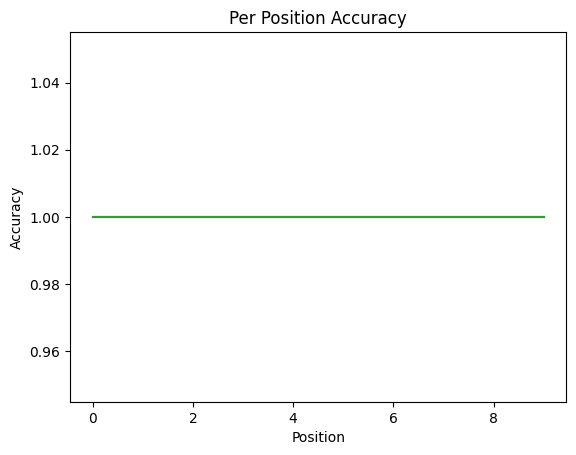

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃         Test metric         ┃        DataLoader 0         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          test_loss          │    0.0016934204613789916    │
│ test_per_pos_acc_mean_epoch │             1.0             │
│       test_perplexity       │     1.0016947984695435      │
│     test_seq_acc_epoch      │             1.0             │
└─────────────────────────────┴─────────────────────────────┘

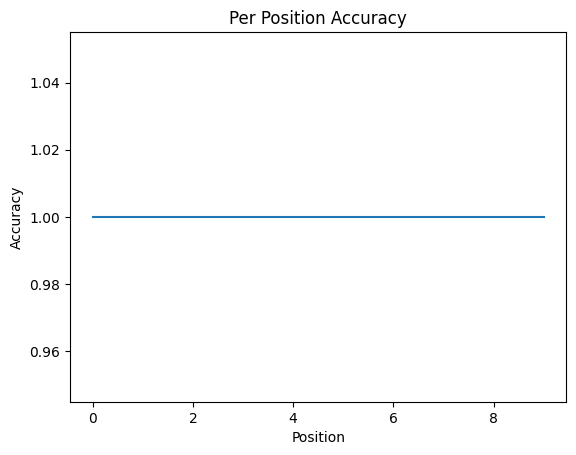

In [79]:
# model performance on the training set
trainer.test(model=lit_model, dataloaders=train_dl)
plt.show()
# model performance on the validation set
trainer.test(model=lit_model, dataloaders=val_dl)
plt.show()


## Test on normal test set that is separated from training and validation set

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃         Test metric         ┃        DataLoader 0         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          test_loss          │    0.0017181920120492578    │
│ test_per_pos_acc_mean_epoch │             1.0             │
│       test_perplexity       │     1.0017197132110596      │
│     test_seq_acc_epoch      │             1.0             │
└─────────────────────────────┴─────────────────────────────┘

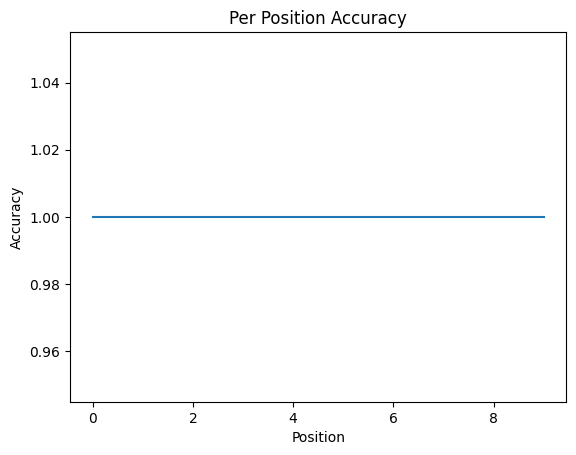

In [80]:
reverse_vocab_map = {i: word for word, i in vocab_map.items()}
# test the model on the test set
trainer.test(model=lit_model, dataloaders=test_dl)
plt.show()

## Test on counterfactual context

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃         Test metric         ┃        DataLoader 0         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          test_loss          │      4.313456058502197      │
│ test_per_pos_acc_mean_epoch │      0.706000030040741      │
│       test_perplexity       │      74.69820404052734      │
│     test_seq_acc_epoch      │    0.009999999776482582     │
└─────────────────────────────┴─────────────────────────────┘

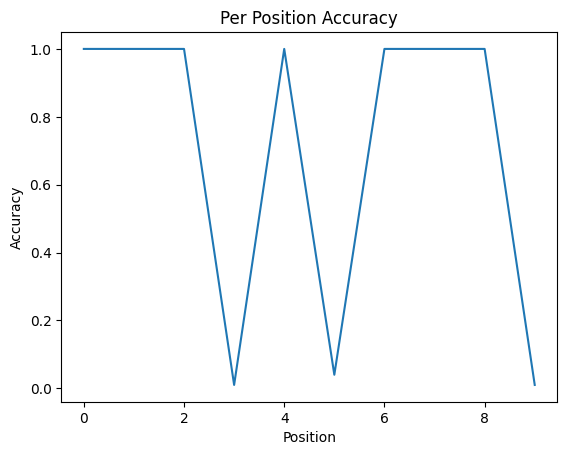

Input: aaren has last name niemiel [sep] aaren has last name
Predicted: has last name durland [sep] amalle has last name durland
Target: has last name niemiel [sep] aaren has last name niemiel
Pretrained Knowledge:
aaren has last name durland
amalle has last name niemiel 

Input: aarika has last name mcleskey [sep] aarika has last name
Predicted: has last name robitaille [sep] aeriell has last name robitaille
Target: has last name mcleskey [sep] aarika has last name mcleskey
Pretrained Knowledge:
aarika has last name robitaille
adiana has last name mcleskey 

Input: abagael has last name keehan [sep] abagael has last name
Predicted: has last name sjogren [sep] ailsun has last name sjogren
Target: has last name keehan [sep] abagael has last name keehan
Pretrained Knowledge:
abagael has last name sjogren
ailsun has last name keehan 

Input: abagail has last name lantrip [sep] abagail has last name
Predicted: has last name mengsteab [sep] ailina has last name mengsteab
Target: has last na

In [81]:
def decode_sequence(sequence, reverse_vocab_map):
    """Decode a sequence of IDs back to words using the reverse vocabulary map."""
    return ' '.join([reverse_vocab_map.get(token_id, '[UNK]') for token_id in sequence])


def mismatch_seq_print_counter(mismatch, reverse_vocab_map, max_examples=6):
    for mismatch in lit_model.mismatched_sequences[:max_examples]:
        input_seq = decode_sequence(mismatch['input'], reverse_vocab_map)
        predicted_seq = decode_sequence(mismatch['predicted'], reverse_vocab_map)
        target_seq = decode_sequence(mismatch['target'], reverse_vocab_map)
        first_name = input_seq.split(' ')[0]
        last_name = target_seq.split(' ')[-1]
        # find last name of first name in training data
        
        # Capitalize the first character of the first name or upper the last name
        if first_name.capitalize() in first_names:
            trained_last_name = last_names[first_names.index(first_name.capitalize())]
        else:
            trained_last_name = first_names[last_names.index(last_name.upper())]
        if last_name.upper() in last_names:
            trained_first_name = first_names[last_names.index(last_name.upper())]
        else:
            trained_first_name = last_names[first_names.index(first_name.capitalize())]
        
        print(f"Input: {input_seq}")
        print(f"Predicted: {predicted_seq}")
        print(f"Target: {target_seq}")
        print("Pretrained Knowledge:")
        print(f"{first_name} has last name {trained_last_name.lower()}")
        print(f"{trained_first_name.lower()} has last name {last_name} \n")

# test the model on the test set
trainer.test(model=lit_model, dataloaders=test_dl_counterfactual)
plt.show()
mismatch_seq_print_counter(lit_model.mismatched_sequences, reverse_vocab_map)

## Test on irrelevant counterfactual context (both first and last name changed in context)

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃         Test metric         ┃        DataLoader 0         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          test_loss          │      4.495903491973877      │
│ test_per_pos_acc_mean_epoch │     0.7029999494552612      │
│       test_perplexity       │      89.64913177490234      │
│     test_seq_acc_epoch      │             0.0             │
└─────────────────────────────┴─────────────────────────────┘

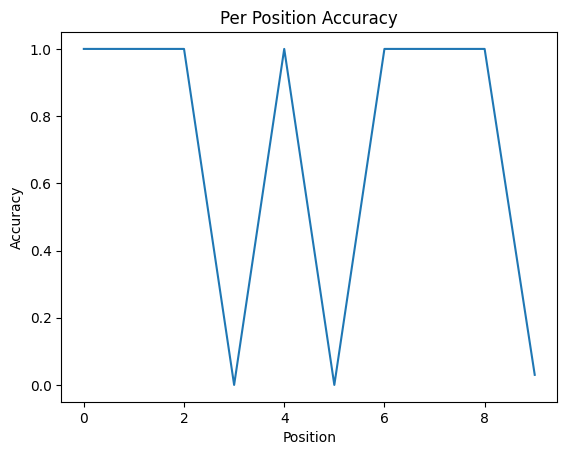

Input: aaren has last name niemiel [sep] aaren has last name
Predicted: has last name durland [sep] amalle has last name durland
Target: has last name niemiel [sep] aaren has last name niemiel
Pretrained Knowledge:
aaren has last/first name durland
niemiel has first/last name amalle
amalle has last/first name niemiel 

Input: aarika has last name mcleskey [sep] aarika has last name
Predicted: has last name robitaille [sep] aeriell has last name robitaille
Target: has last name mcleskey [sep] aarika has last name mcleskey
Pretrained Knowledge:
aarika has last/first name robitaille
mcleskey has first/last name adiana
aeriell has last/first name coble 

Input: abagael has last name keehan [sep] abagael has last name
Predicted: has last name sjogren [sep] ailsun has last name sjogren
Target: has last name keehan [sep] abagael has last name keehan
Pretrained Knowledge:
abagael has last/first name sjogren
keehan has first/last name ailsun
ailsun has last/first name keehan 

Input: abagail ha

In [82]:

def mismatch_seq_print_irrelevant(mismatch, reverse_vocab_map, max_examples=6):
    
    for mismatch in lit_model.mismatched_sequences[:max_examples]:
        input_seq = decode_sequence(mismatch['input'], reverse_vocab_map)
        predicted_seq = decode_sequence(mismatch['predicted'], reverse_vocab_map)
        target_seq = decode_sequence(mismatch['target'], reverse_vocab_map)
        first_name_ctx = input_seq.split(' ')[0]
        last_name_ctx = input_seq.split(" [sep] ")[0].split(' ')[-1]
        first_name_pred = predicted_seq.split(' [sep] ')[1].split(' ')[0]
        # find last name of first name in training data
        # Capitalize the first character of the first name
        trained_last_name = last_names[first_names.index(first_name_ctx.capitalize())]
        context_last_to_first_name = first_names[last_names.index(last_name_ctx.upper())] if last_name_ctx.upper() in last_names else last_names[first_names.index(last_name_ctx.capitalize())]
        first_name_pred_last_name = last_names[first_names.index(first_name_pred.capitalize())] if first_name_pred.capitalize() in first_names else first_names[last_names.index(first_name_pred.upper())]
        print(f"Input: {input_seq}")
        print(f"Predicted: {predicted_seq}")
        print(f"Target: {target_seq}")
        print("Pretrained Knowledge:")
        print(f"{first_name_ctx} has last/first name {trained_last_name.lower()}")
        print(f"{last_name_ctx} has first/last name {context_last_to_first_name.lower()}")
        print(f"{first_name_pred} has last/first name {first_name_pred_last_name.lower()} \n")


# test the model on the test set
trainer.test(model=lit_model, dataloaders=test_dl_counterfactual_irrelevant)
plt.show()
mismatch_seq_print_irrelevant(lit_model.mismatched_sequences, reverse_vocab_map)

## Test on empty context

In [91]:
test_data_empty_ctx = [f' [SEP] {sentence}' for sentence in data_orginal]
print(test_data_empty_ctx[:5])

tokenized_data = [sentence.strip().lower().split(' ') for sentence in tqdm(test_data_empty_ctx)]

integer_ids = [torch.tensor([vocab_map.get(token, vocab_map['[UNK]']) for token in tokens]) for tokens in tqdm(tokenized_data)]
integer_ids = torch.tensor(np.array(integer_ids))


# create dataset and dataloader
x = integer_ids[:, :-1]
y = integer_ids[:, 1:]
test_dataset_empty_ctx = torch.utils.data.TensorDataset(x, y)
test_dataset_empty_ctx = test_dataset_empty_ctx[:100] # NOTE: smaller dataset for testing
test_dl_empty_ctx = torch.utils.data.DataLoader(test_dataset_empty_ctx, batch_size=args.batch_size, shuffle=False)




[' [SEP] Aaren has last name DURLAND', ' [SEP] Aarika has last name ROBITAILLE', ' [SEP] Abagael has last name SJOGREN', ' [SEP] Abagail has last name MENGSTEAB', ' [SEP] Abbe has last name OEHLENSCHLAGE']


100%|██████████| 300/300 [00:00<00:00, 106122.22it/s]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃         Test metric         ┃        DataLoader 0         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          test_loss          │      13.8836669921875       │
│ test_per_pos_acc_mean_epoch │     0.41599997878074646     │
│       test_perplexity       │         1070533.75          │
│     test_seq_acc_epoch      │             0.0             │
└─────────────────────────────┴─────────────────────────────┘

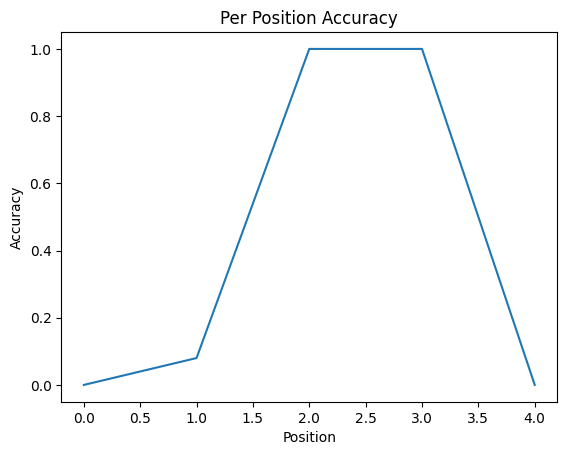

Input: [sep] aaren has last name
Predicted: has last last name [sep]
Target: aaren has last name durland

Input: [sep] aarika has last name
Predicted: has last last name [sep]
Target: aarika has last name robitaille

Input: [sep] abagael has last name
Predicted: has last last name [sep]
Target: abagael has last name sjogren

Input: [sep] abagail has last name
Predicted: has last last name [sep]
Target: abagail has last name mengsteab

Input: [sep] abbe has last name
Predicted: has last last name [sep]
Target: abbe has last name oehlenschlage

Input: [sep] abbey has last name
Predicted: has last last name [sep]
Target: abbey has last name armendariz



In [90]:
def mismatch_seq_print_empty(mismatch, reverse_vocab_map, max_examples=6):
    for mismatch in lit_model.mismatched_sequences[:max_examples]:
        input_seq = decode_sequence(mismatch['input'], reverse_vocab_map)
        predicted_seq = decode_sequence(mismatch['predicted'], reverse_vocab_map)
        target_seq = decode_sequence(mismatch['target'], reverse_vocab_map)
        
        print(f"Input: {input_seq}")
        print(f"Predicted: {predicted_seq}")
        print(f"Target: {target_seq}\n")
        
# test the model on the test set
lit_model.mismatched_sequences.clear()

trainer.test(model=lit_model, dataloaders=test_dl_empty_ctx)
plt.show()
mismatch_seq_print_empty(lit_model.mismatched_sequences, reverse_vocab_map)

## Test on irrelevant counterfactual context (only first name changed in context)

In [92]:
def mismatch_seq_print_irrelevant_first_name(mismatch, reverse_vocab_map, max_examples=6):
    
    for mismatch in lit_model.mismatched_sequences[:max_examples]:
        input_seq = decode_sequence(mismatch['input'], reverse_vocab_map)
        predicted_seq = decode_sequence(mismatch['predicted'], reverse_vocab_map)
        target_seq = decode_sequence(mismatch['target'], reverse_vocab_map)
        first_name_ctx = input_seq.split(' ')[0]
        last_name_ctx = input_seq.split(" [sep] ")[0].split(' ')[-1]
        first_name_pred = predicted_seq.split(' [sep] ')[1].split(' ')[0]
        # find last name of first name in training data
        # Capitalize the first character of the first name
        trained_last_name = last_names[first_names.index(first_name_ctx.capitalize())]
        context_last_to_first_name = first_names[last_names.index(last_name_ctx.upper())]
        first_name_pred_last_name = last_names[first_names.index(first_name_pred.capitalize())]
        print(f"Input: {input_seq}")
        print(f"Predicted: {predicted_seq}")
        print(f"Target: {target_seq}")
        print("Pretrained Knowledge:")
        print(f"{first_name_ctx} has last name {trained_last_name.lower()}")
        print(f"{last_name_ctx} has first name {context_last_to_first_name.lower()}")
        print(f"{first_name_pred} has last name {first_name_pred_last_name.lower()} \n")

100%|██████████| 300/300 [00:00<00:00, 898137.90it/s]


['Ally has last name DURLAND [SEP] Aaren has last name DURLAND', 'Agna has last name ROBITAILLE [SEP] Aarika has last name ROBITAILLE', 'Aeriel has last name SJOGREN [SEP] Abagael has last name SJOGREN', 'Adina has last name MENGSTEAB [SEP] Abagail has last name MENGSTEAB', 'Adriana has last name OEHLENSCHLAGE [SEP] Abbe has last name OEHLENSCHLAGE']


100%|██████████| 300/300 [00:00<00:00, 86581.66it/s]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃         Test metric         ┃        DataLoader 0         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          test_loss          │      3.413283586502075      │
│ test_per_pos_acc_mean_epoch │     0.7590000033378601      │
│       test_perplexity       │      30.36478614807129      │
│     test_seq_acc_epoch      │             0.0             │
└─────────────────────────────┴─────────────────────────────┘

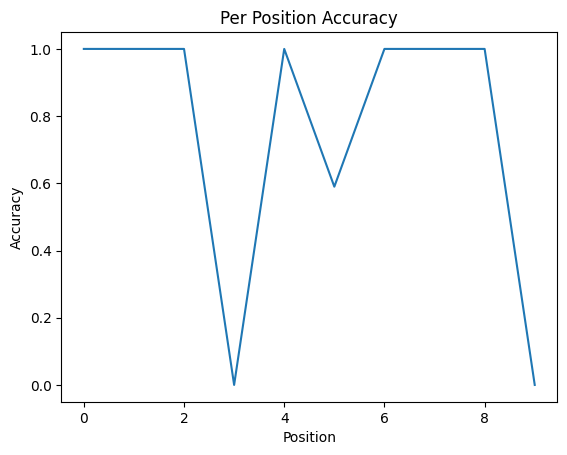

Input: ally has last name durland [sep] aaren has last name
Predicted: has last name hurrington [sep] aaren has last name hurrington
Target: has last name durland [sep] aaren has last name durland
Pretrained Knowledge:
ally has last name hurrington
durland has first name aaren
aaren has last name durland 

Input: agna has last name robitaille [sep] aarika has last name
Predicted: has last name scharer [sep] alene has last name scharer
Target: has last name robitaille [sep] aarika has last name robitaille
Pretrained Knowledge:
agna has last name scharer
robitaille has first name aarika
alene has last name pettus 

Input: aeriel has last name sjogren [sep] abagael has last name
Predicted: has last name kanoa [sep] abagael has last name kanoa
Target: has last name sjogren [sep] abagael has last name sjogren
Pretrained Knowledge:
aeriel has last name kanoa
sjogren has first name abagael
abagael has last name sjogren 

Input: adina has last name mengsteab [sep] abagail has last name
Predict

In [93]:
test_data_counterfactual_irrelevant_first_name_change = [f'{first_names[np.random.randint(len(first_names))]} {" ".join(sentence.split(" ")[1:])}' for sentence in data]
#test_data_counterfactual_irrelevant_first_name_change = [f'{test_data_counterfactual_irrelevant_first_name_change[i]} [SEP] {data[i]}' for i in range(len(data))]
tokenized_data = [sentence.strip().lower().split(' ') for sentence in tqdm(test_data_counterfactual_irrelevant_first_name_change)]
print(test_data_counterfactual_irrelevant_first_name_change[:5])
integer_ids = [torch.tensor([vocab_map.get(token, vocab_map['[UNK]']) for token in tokens]) for tokens in tqdm(tokenized_data)]
integer_ids = torch.tensor(np.array(integer_ids))


# create dataset and dataloader
x = integer_ids[:, :-1]
y = integer_ids[:, 1:]
test_data_counterfactual_irrelevant_first_name_change = torch.utils.data.TensorDataset(x, y)
test_data_counterfactual_irrelevant_first_name_change = test_data_counterfactual_irrelevant_first_name_change[:100] # NOTE: smaller dataset for testing
test_data_counterfactual_irrelevant_first_name_change = torch.utils.data.DataLoader(test_data_counterfactual_irrelevant_first_name_change, batch_size=args.batch_size, shuffle=False)

# test on the test set
lit_model.mismatched_sequences.clear()
trainer.test(model=lit_model, dataloaders=test_data_counterfactual_irrelevant_first_name_change)
plt.show()
mismatch_seq_print_irrelevant_first_name(lit_model.mismatched_sequences, reverse_vocab_map)